In [1]:
%matplotlib inline

import matplotlib
import numpy as np
import matplotlib.pyplot as plt

In [2]:
import argparse
import torch
import torch.utils.data
from torch import nn, optim
from torch.autograd import Variable
from torch.nn import functional as F
from torchvision import datasets, transforms
from torchvision.utils import save_image

In [10]:
args = type('', (), {})() # Google "creating an empty object in Python"
args.cuda = torch.cuda.is_available()
args.batch_size = 128
args.epochs = 5
args.seed = 1
args.log_interval = 50 # how many batches to wait before logging training status

args.lr = 0.01
args.momentum = 0.5

In [4]:
torch.manual_seed(args.seed)
if args.cuda:
    torch.cuda.manual_seed(args.seed)

In [5]:
kwargs = {'num_workers': 1, 'pin_memory': True} if args.cuda else {}
train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('./data', train=True, download=True,
                   transform=transforms.ToTensor()),
    batch_size=args.batch_size, shuffle=True, **kwargs)
test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('./data', train=False, transform=transforms.ToTensor()),
    batch_size=args.batch_size, shuffle=False, **kwargs)

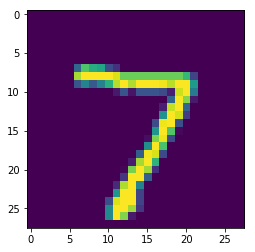

In [6]:
def get_test_img(ind=0):
    batch_idx, (data, ys) = next(enumerate(test_loader))
    test_img = Variable(data[ind:ind+1])
    return test_img

def show_test_img(ind=0):
    plt.imshow(get_test_img(ind).view(28,28).data)
    
def show_img(img):
    plt.imshow(img.view(28,28).data)
    
show_test_img()

In [11]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)

model = Net()
if args.cuda:
    model.cuda()

optimizer = optim.SGD(model.parameters(), lr=args.lr, momentum=args.momentum)

def train(epoch):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        if args.cuda:
            data, target = data.cuda(), target.cuda()
        data, target = Variable(data), Variable(target)
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % args.log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.data[0]))

def test():
    model.eval()
    test_loss = 0
    correct = 0
    for data, target in test_loader:
        if args.cuda:
            data, target = data.cuda(), target.cuda()
        data, target = Variable(data, volatile=True), Variable(target)
        output = model(data)
        test_loss += F.nll_loss(output, target, size_average=False).data[0] # sum up batch loss
        pred = output.data.max(1, keepdim=True)[1] # get the index of the max log-probability
        correct += pred.eq(target.data.view_as(pred)).long().cpu().sum()

    test_loss /= len(test_loader.dataset)
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))


for epoch in range(1, args.epochs + 1):
    train(epoch)
    test()

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.316182
Train Epoch: 1 [6400/60000 (11%)]	Loss: 2.305709
Train Epoch: 1 [12800/60000 (21%)]	Loss: 2.285953
Train Epoch: 1 [19200/60000 (32%)]	Loss: 2.303589
Train Epoch: 1 [25600/60000 (43%)]	Loss: 2.285993
Train Epoch: 1 [32000/60000 (53%)]	Loss: 2.288840
Train Epoch: 1 [38400/60000 (64%)]	Loss: 2.266617
Train Epoch: 1 [44800/60000 (75%)]	Loss: 2.221663
Train Epoch: 1 [51200/60000 (85%)]	Loss: 2.150324
Train Epoch: 1 [57600/60000 (96%)]	Loss: 1.886235

Test set: Average loss: 1.5858, Accuracy: 7007/10000 (70%)

Train Epoch: 2 [0/60000 (0%)]	Loss: 1.819156
Train Epoch: 2 [6400/60000 (11%)]	Loss: 1.361695
Train Epoch: 2 [12800/60000 (21%)]	Loss: 1.148941
Train Epoch: 2 [19200/60000 (32%)]	Loss: 1.068462
Train Epoch: 2 [25600/60000 (43%)]	Loss: 0.998754
Train Epoch: 2 [32000/60000 (53%)]	Loss: 0.948352
Train Epoch: 2 [38400/60000 (64%)]	Loss: 0.766156
Train Epoch: 2 [44800/60000 (75%)]	Loss: 0.671182
Train Epoch: 2 [51200/60000 (85%)]	Loss: 0.698674
T

In [21]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc = nn.Linear(28*28, 10)

    def forward(self, x):
        x = self.fc(x)
        return F.log_softmax(x, dim=-1).squeeze()

model = Net()
if args.cuda:
    model.cuda()

optimizer = optim.SGD(model.parameters(), lr=args.lr, momentum=args.momentum)

def train(epoch):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        if args.cuda:
            data, target = data.cuda(), target.cuda()
        data = data.view(data.shape[0], data.shape[1], 28*28)
        data, target = Variable(data), Variable(target)
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % args.log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.data[0]))

def test():
    model.eval()
    test_loss = 0
    correct = 0
    for data, target in test_loader:
        if args.cuda:
            data, target = data.cuda(), target.cuda()
        data = data.view(data.shape[0], data.shape[1], 28*28)
        data, target = Variable(data, volatile=True), Variable(target)
        output = model(data)
        test_loss += F.nll_loss(output, target, size_average=False).data[0] # sum up batch loss
        pred = output.data.max(1, keepdim=True)[1] # get the index of the max log-probability
        correct += pred.eq(target.data.view_as(pred)).long().cpu().sum()

    test_loss /= len(test_loader.dataset)
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))


for epoch in range(1, args.epochs + 1):
    train(epoch)
    test()

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.363132
Train Epoch: 1 [6400/60000 (11%)]	Loss: 1.572030
Train Epoch: 1 [12800/60000 (21%)]	Loss: 1.265632
Train Epoch: 1 [19200/60000 (32%)]	Loss: 0.919833
Train Epoch: 1 [25600/60000 (43%)]	Loss: 0.817889
Train Epoch: 1 [32000/60000 (53%)]	Loss: 0.805987
Train Epoch: 1 [38400/60000 (64%)]	Loss: 0.683124
Train Epoch: 1 [44800/60000 (75%)]	Loss: 0.764686
Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.651697
Train Epoch: 1 [57600/60000 (96%)]	Loss: 0.568247

Test set: Average loss: 0.6004, Accuracy: 8664/10000 (87%)

Train Epoch: 2 [0/60000 (0%)]	Loss: 0.658809
Train Epoch: 2 [6400/60000 (11%)]	Loss: 0.503953
Train Epoch: 2 [12800/60000 (21%)]	Loss: 0.495537
Train Epoch: 2 [19200/60000 (32%)]	Loss: 0.605426
Train Epoch: 2 [25600/60000 (43%)]	Loss: 0.595772
Train Epoch: 2 [32000/60000 (53%)]	Loss: 0.610346
Train Epoch: 2 [38400/60000 (64%)]	Loss: 0.546847
Train Epoch: 2 [44800/60000 (75%)]	Loss: 0.518362
Train Epoch: 2 [51200/60000 (85%)]	Loss: 0.555445
T

In [22]:
def sample_gumbel(shape, eps=1e-20):
    U = torch.rand(shape)
    return -Variable(torch.log(-torch.log(U + eps) + eps))

def gumbel_softmax_sample(logits, temperature):
    y = logits + sample_gumbel(logits.size())
    return F.softmax(y / temperature, dim=-1)

def gumbel_softmax(logits, temperature):
    """
    input: [*, n_class]
    return: [*, n_class] an one-hot vector
    """
    y = gumbel_softmax_sample(logits, temperature)
    shape = y.size()
    _, ind = y.max(dim=-1)
    y_hard = torch.zeros_like(y).view(-1, shape[-1])
    y_hard.scatter_(1, ind.view(-1, 1), 1)
    y_hard = y_hard.view(*shape)
    return (y_hard - y).detach() + y

In [38]:
# 1 bit is optimal. Gets to 20%.
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.t0 = nn.Linear(28*28, 128)
        self.o0 = nn.Linear(128, 2)
        self.decoder = nn.Linear(2, 10)

    def forward(self, x):
        h0 = self.t0(x)
        o0 = self.o0(h0)
        g0 = gumbel_softmax(o0, temperature=1.)
        
        res = self.decoder(g0)
        return F.log_softmax(res, dim=-1).squeeze()

model = Net()
if args.cuda:
    model.cuda()

optimizer = optim.SGD(model.parameters(), lr=args.lr, momentum=args.momentum)

def train(epoch):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        if args.cuda:
            data, target = data.cuda(), target.cuda()
        data = data.view(data.shape[0], data.shape[1], 28*28)
        data, target = Variable(data), Variable(target)
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % args.log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.data[0]))

def test():
    model.eval()
    test_loss = 0
    correct = 0
    for data, target in test_loader:
        if args.cuda:
            data, target = data.cuda(), target.cuda()
        data = data.view(data.shape[0], data.shape[1], 28*28)
        data, target = Variable(data, volatile=True), Variable(target)
        output = model(data)
        test_loss += F.nll_loss(output, target, size_average=False).data[0] # sum up batch loss
        pred = output.data.max(1, keepdim=True)[1] # get the index of the max log-probability
        correct += pred.eq(target.data.view_as(pred)).long().cpu().sum()

    test_loss /= len(test_loader.dataset)
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))


for epoch in range(1, args.epochs + 1):
    train(epoch)
    test()

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.355696
Train Epoch: 1 [6400/60000 (11%)]	Loss: 2.414452
Train Epoch: 1 [12800/60000 (21%)]	Loss: 2.330211
Train Epoch: 1 [19200/60000 (32%)]	Loss: 2.306528
Train Epoch: 1 [25600/60000 (43%)]	Loss: 2.286813
Train Epoch: 1 [32000/60000 (53%)]	Loss: 2.289404
Train Epoch: 1 [38400/60000 (64%)]	Loss: 2.256113
Train Epoch: 1 [44800/60000 (75%)]	Loss: 2.238576
Train Epoch: 1 [51200/60000 (85%)]	Loss: 2.190476
Train Epoch: 1 [57600/60000 (96%)]	Loss: 2.201020

Test set: Average loss: 2.1908, Accuracy: 1741/10000 (17%)

Train Epoch: 2 [0/60000 (0%)]	Loss: 2.202140
Train Epoch: 2 [6400/60000 (11%)]	Loss: 2.161242
Train Epoch: 2 [12800/60000 (21%)]	Loss: 2.164098
Train Epoch: 2 [19200/60000 (32%)]	Loss: 2.163002
Train Epoch: 2 [25600/60000 (43%)]	Loss: 2.159225
Train Epoch: 2 [32000/60000 (53%)]	Loss: 2.099027
Train Epoch: 2 [38400/60000 (64%)]	Loss: 2.136655
Train Epoch: 2 [44800/60000 (75%)]	Loss: 2.101162
Train Epoch: 2 [51200/60000 (85%)]	Loss: 2.072610
T

In [39]:
# 2 bits is already not optimal. Best I could get is around 38%, if you train for longer.
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.t0 = nn.Linear(28*28, 128)
        self.o0 = nn.Linear(128, 2)
        self.t1 = nn.Linear(128, 128)
        self.o1 = nn.Linear(128, 2)
        self.decoder = nn.Linear(4, 10)

    def forward(self, x):
        h0 = self.t0(x)
        o0 = self.o0(h0)
        g0 = gumbel_softmax(o0, temperature=1.)
        
        h1 = self.t1(h0)
        o1 = self.o1(h1)
        g1 = gumbel_softmax(o1, temperature=1.)
        
        g = torch.cat([g0,g1], dim=-1)
        
        res = self.decoder(g)
        return F.log_softmax(res, dim=-1).squeeze()

model = Net()
if args.cuda:
    model.cuda()

optimizer = optim.SGD(model.parameters(), lr=args.lr, momentum=args.momentum)

def train(epoch):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        if args.cuda:
            data, target = data.cuda(), target.cuda()
        data = data.view(data.shape[0], data.shape[1], 28*28)
        data, target = Variable(data), Variable(target)
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % args.log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.data[0]))

def test():
    model.eval()
    test_loss = 0
    correct = 0
    for data, target in test_loader:
        if args.cuda:
            data, target = data.cuda(), target.cuda()
        data = data.view(data.shape[0], data.shape[1], 28*28)
        data, target = Variable(data, volatile=True), Variable(target)
        output = model(data)
        test_loss += F.nll_loss(output, target, size_average=False).data[0] # sum up batch loss
        pred = output.data.max(1, keepdim=True)[1] # get the index of the max log-probability
        correct += pred.eq(target.data.view_as(pred)).long().cpu().sum()

    test_loss /= len(test_loader.dataset)
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))


for epoch in range(1, 10 + 1):
    train(epoch)
    test()

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.314123
Train Epoch: 1 [6400/60000 (11%)]	Loss: 2.404693
Train Epoch: 1 [12800/60000 (21%)]	Loss: 2.402544
Train Epoch: 1 [19200/60000 (32%)]	Loss: 2.354995
Train Epoch: 1 [25600/60000 (43%)]	Loss: 2.328979
Train Epoch: 1 [32000/60000 (53%)]	Loss: 2.327908
Train Epoch: 1 [38400/60000 (64%)]	Loss: 2.289270
Train Epoch: 1 [44800/60000 (75%)]	Loss: 2.304797
Train Epoch: 1 [51200/60000 (85%)]	Loss: 2.267944
Train Epoch: 1 [57600/60000 (96%)]	Loss: 2.254883

Test set: Average loss: 2.2523, Accuracy: 1636/10000 (16%)

Train Epoch: 2 [0/60000 (0%)]	Loss: 2.227121
Train Epoch: 2 [6400/60000 (11%)]	Loss: 2.231308
Train Epoch: 2 [12800/60000 (21%)]	Loss: 2.196940
Train Epoch: 2 [19200/60000 (32%)]	Loss: 2.232091
Train Epoch: 2 [25600/60000 (43%)]	Loss: 2.195231
Train Epoch: 2 [32000/60000 (53%)]	Loss: 2.238718
Train Epoch: 2 [38400/60000 (64%)]	Loss: 2.160386
Train Epoch: 2 [44800/60000 (75%)]	Loss: 2.198435
Train Epoch: 2 [51200/60000 (85%)]	Loss: 2.189796
T

In [40]:
# 3 bits... 64%
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.t0 = nn.Linear(28*28, 128)
        self.o0 = nn.Linear(128, 2)
        self.t1 = nn.Linear(128, 128)
        self.o1 = nn.Linear(128, 2)
        self.t2 = nn.Linear(128, 128)
        self.o2 = nn.Linear(128, 2)
        self.decoder = nn.Linear(6, 10)

    def forward(self, x):
        h0 = self.t0(x)
        o0 = self.o0(h0)
        g0 = gumbel_softmax(o0, temperature=1.)
        
        h1 = self.t1(h0)
        o1 = self.o1(h1)
        g1 = gumbel_softmax(o1, temperature=1.)
        
        h2 = self.t1(h1)
        o2 = self.o1(h2)
        g2 = gumbel_softmax(o2, temperature=1.)
        
        g = torch.cat([g0,g1,g2], dim=-1)
        
        res = self.decoder(g)
        return F.log_softmax(res, dim=-1).squeeze()

model = Net()
if args.cuda:
    model.cuda()

optimizer = optim.SGD(model.parameters(), lr=args.lr, momentum=args.momentum)

def train(epoch):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        if args.cuda:
            data, target = data.cuda(), target.cuda()
        data = data.view(data.shape[0], data.shape[1], 28*28)
        data, target = Variable(data), Variable(target)
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % args.log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.data[0]))

def test():
    model.eval()
    test_loss = 0
    correct = 0
    for data, target in test_loader:
        if args.cuda:
            data, target = data.cuda(), target.cuda()
        data = data.view(data.shape[0], data.shape[1], 28*28)
        data, target = Variable(data, volatile=True), Variable(target)
        output = model(data)
        test_loss += F.nll_loss(output, target, size_average=False).data[0] # sum up batch loss
        pred = output.data.max(1, keepdim=True)[1] # get the index of the max log-probability
        correct += pred.eq(target.data.view_as(pred)).long().cpu().sum()

    test_loss /= len(test_loader.dataset)
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))


for epoch in range(1, 10 + 1):
    train(epoch)
    test()

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.412082
Train Epoch: 1 [6400/60000 (11%)]	Loss: 2.333133
Train Epoch: 1 [12800/60000 (21%)]	Loss: 2.276598
Train Epoch: 1 [19200/60000 (32%)]	Loss: 2.291589
Train Epoch: 1 [25600/60000 (43%)]	Loss: 2.288403
Train Epoch: 1 [32000/60000 (53%)]	Loss: 2.276601
Train Epoch: 1 [38400/60000 (64%)]	Loss: 2.282813
Train Epoch: 1 [44800/60000 (75%)]	Loss: 2.282968
Train Epoch: 1 [51200/60000 (85%)]	Loss: 2.241323
Train Epoch: 1 [57600/60000 (96%)]	Loss: 2.213143

Test set: Average loss: 2.2438, Accuracy: 1855/10000 (19%)

Train Epoch: 2 [0/60000 (0%)]	Loss: 2.221252
Train Epoch: 2 [6400/60000 (11%)]	Loss: 2.197503
Train Epoch: 2 [12800/60000 (21%)]	Loss: 2.230546
Train Epoch: 2 [19200/60000 (32%)]	Loss: 2.161000
Train Epoch: 2 [25600/60000 (43%)]	Loss: 2.066570
Train Epoch: 2 [32000/60000 (53%)]	Loss: 2.110044
Train Epoch: 2 [38400/60000 (64%)]	Loss: 2.020872
Train Epoch: 2 [44800/60000 (75%)]	Loss: 2.059639
Train Epoch: 2 [51200/60000 (85%)]	Loss: 1.995900
T

In [41]:
for epoch in range(1, 10 + 1):
    train(epoch)
    test()

Train Epoch: 1 [0/60000 (0%)]	Loss: 1.194784
Train Epoch: 1 [6400/60000 (11%)]	Loss: 1.049554
Train Epoch: 1 [12800/60000 (21%)]	Loss: 0.983260
Train Epoch: 1 [19200/60000 (32%)]	Loss: 1.160934
Train Epoch: 1 [25600/60000 (43%)]	Loss: 1.168787
Train Epoch: 1 [32000/60000 (53%)]	Loss: 1.186473
Train Epoch: 1 [38400/60000 (64%)]	Loss: 1.093644
Train Epoch: 1 [44800/60000 (75%)]	Loss: 1.154122
Train Epoch: 1 [51200/60000 (85%)]	Loss: 1.181486
Train Epoch: 1 [57600/60000 (96%)]	Loss: 1.111068

Test set: Average loss: 1.0841, Accuracy: 6100/10000 (61%)

Train Epoch: 2 [0/60000 (0%)]	Loss: 1.011595
Train Epoch: 2 [6400/60000 (11%)]	Loss: 0.959310
Train Epoch: 2 [12800/60000 (21%)]	Loss: 1.092860
Train Epoch: 2 [19200/60000 (32%)]	Loss: 1.042506
Train Epoch: 2 [25600/60000 (43%)]	Loss: 1.100157
Train Epoch: 2 [32000/60000 (53%)]	Loss: 0.993586
Train Epoch: 2 [38400/60000 (64%)]	Loss: 1.163849
Train Epoch: 2 [44800/60000 (75%)]	Loss: 1.184312
Train Epoch: 2 [51200/60000 (85%)]	Loss: 1.013959
T

In [42]:
for epoch in range(1, 10 + 1):
    train(epoch)
    test()

Train Epoch: 1 [0/60000 (0%)]	Loss: 1.021077
Train Epoch: 1 [6400/60000 (11%)]	Loss: 1.027678
Train Epoch: 1 [12800/60000 (21%)]	Loss: 1.189967
Train Epoch: 1 [19200/60000 (32%)]	Loss: 1.187884
Train Epoch: 1 [25600/60000 (43%)]	Loss: 1.244993
Train Epoch: 1 [32000/60000 (53%)]	Loss: 0.983702
Train Epoch: 1 [38400/60000 (64%)]	Loss: 1.002815
Train Epoch: 1 [44800/60000 (75%)]	Loss: 0.869544
Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.971817
Train Epoch: 1 [57600/60000 (96%)]	Loss: 0.950049

Test set: Average loss: 1.0129, Accuracy: 6373/10000 (64%)

Train Epoch: 2 [0/60000 (0%)]	Loss: 1.069934
Train Epoch: 2 [6400/60000 (11%)]	Loss: 1.031826
Train Epoch: 2 [12800/60000 (21%)]	Loss: 0.948678
Train Epoch: 2 [19200/60000 (32%)]	Loss: 1.109175
Train Epoch: 2 [25600/60000 (43%)]	Loss: 0.934683
Train Epoch: 2 [32000/60000 (53%)]	Loss: 0.915432
Train Epoch: 2 [38400/60000 (64%)]	Loss: 0.966024
Train Epoch: 2 [44800/60000 (75%)]	Loss: 0.908861
Train Epoch: 2 [51200/60000 (85%)]	Loss: 0.917451
T

In [43]:
# 4 bits... 72% max
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.t0 = nn.Linear(28*28, 128)
        self.o0 = nn.Linear(128, 2)
        self.t1 = nn.Linear(128, 128)
        self.o1 = nn.Linear(128, 2)
        self.t2 = nn.Linear(128, 128)
        self.o2 = nn.Linear(128, 2)
        self.t3 = nn.Linear(128, 128)
        self.o3 = nn.Linear(128, 2)
        self.decoder = nn.Linear(8, 10)

    def forward(self, x):
        h0 = self.t0(x)
        o0 = self.o0(h0)
        g0 = gumbel_softmax(o0, temperature=1.)
        
        h1 = self.t1(h0)
        o1 = self.o1(h1)
        g1 = gumbel_softmax(o1, temperature=1.)
        
        h2 = self.t1(h1)
        o2 = self.o1(h2)
        g2 = gumbel_softmax(o2, temperature=1.)
        
        h3 = self.t1(h2)
        o3 = self.o1(h3)
        g3 = gumbel_softmax(o3, temperature=1.)
        
        g = torch.cat([g0,g1,g2,g3], dim=-1)
        
        res = self.decoder(g)
        return F.log_softmax(res, dim=-1).squeeze()

model = Net()
if args.cuda:
    model.cuda()

optimizer = optim.SGD(model.parameters(), lr=args.lr, momentum=args.momentum)

def train(epoch):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        if args.cuda:
            data, target = data.cuda(), target.cuda()
        data = data.view(data.shape[0], data.shape[1], 28*28)
        data, target = Variable(data), Variable(target)
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % args.log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.data[0]))

def test():
    model.eval()
    test_loss = 0
    correct = 0
    for data, target in test_loader:
        if args.cuda:
            data, target = data.cuda(), target.cuda()
        data = data.view(data.shape[0], data.shape[1], 28*28)
        data, target = Variable(data, volatile=True), Variable(target)
        output = model(data)
        test_loss += F.nll_loss(output, target, size_average=False).data[0] # sum up batch loss
        pred = output.data.max(1, keepdim=True)[1] # get the index of the max log-probability
        correct += pred.eq(target.data.view_as(pred)).long().cpu().sum()

    test_loss /= len(test_loader.dataset)
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))


for epoch in range(1, 10 + 1):
    train(epoch)
    test()

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.453426
Train Epoch: 1 [6400/60000 (11%)]	Loss: 2.387055
Train Epoch: 1 [12800/60000 (21%)]	Loss: 2.381180
Train Epoch: 1 [19200/60000 (32%)]	Loss: 2.322859
Train Epoch: 1 [25600/60000 (43%)]	Loss: 2.322942
Train Epoch: 1 [32000/60000 (53%)]	Loss: 2.260781
Train Epoch: 1 [38400/60000 (64%)]	Loss: 2.310952
Train Epoch: 1 [44800/60000 (75%)]	Loss: 2.297080
Train Epoch: 1 [51200/60000 (85%)]	Loss: 2.220396
Train Epoch: 1 [57600/60000 (96%)]	Loss: 2.259188

Test set: Average loss: 2.2530, Accuracy: 1637/10000 (16%)

Train Epoch: 2 [0/60000 (0%)]	Loss: 2.228765
Train Epoch: 2 [6400/60000 (11%)]	Loss: 2.249784
Train Epoch: 2 [12800/60000 (21%)]	Loss: 2.205594
Train Epoch: 2 [19200/60000 (32%)]	Loss: 2.182197
Train Epoch: 2 [25600/60000 (43%)]	Loss: 2.178229
Train Epoch: 2 [32000/60000 (53%)]	Loss: 2.141350
Train Epoch: 2 [38400/60000 (64%)]	Loss: 2.169355
Train Epoch: 2 [44800/60000 (75%)]	Loss: 2.101819
Train Epoch: 2 [51200/60000 (85%)]	Loss: 2.114247
T

In [44]:
for epoch in range(1, 10 + 1):
    train(epoch)
    test()

Train Epoch: 1 [0/60000 (0%)]	Loss: 1.181393
Train Epoch: 1 [6400/60000 (11%)]	Loss: 1.118558
Train Epoch: 1 [12800/60000 (21%)]	Loss: 1.091414
Train Epoch: 1 [19200/60000 (32%)]	Loss: 1.058332
Train Epoch: 1 [25600/60000 (43%)]	Loss: 1.196695
Train Epoch: 1 [32000/60000 (53%)]	Loss: 1.099803
Train Epoch: 1 [38400/60000 (64%)]	Loss: 1.124498
Train Epoch: 1 [44800/60000 (75%)]	Loss: 1.044755
Train Epoch: 1 [51200/60000 (85%)]	Loss: 1.085438
Train Epoch: 1 [57600/60000 (96%)]	Loss: 1.041891

Test set: Average loss: 1.0383, Accuracy: 6451/10000 (65%)

Train Epoch: 2 [0/60000 (0%)]	Loss: 1.082539
Train Epoch: 2 [6400/60000 (11%)]	Loss: 1.256646
Train Epoch: 2 [12800/60000 (21%)]	Loss: 1.161012
Train Epoch: 2 [19200/60000 (32%)]	Loss: 1.008558
Train Epoch: 2 [25600/60000 (43%)]	Loss: 1.038643
Train Epoch: 2 [32000/60000 (53%)]	Loss: 0.884259
Train Epoch: 2 [38400/60000 (64%)]	Loss: 1.044907
Train Epoch: 2 [44800/60000 (75%)]	Loss: 0.909212
Train Epoch: 2 [51200/60000 (85%)]	Loss: 1.046031
T

In [45]:
for epoch in range(1, 10 + 1):
    train(epoch)
    test()

Train Epoch: 1 [0/60000 (0%)]	Loss: 0.891909
Train Epoch: 1 [6400/60000 (11%)]	Loss: 0.887145
Train Epoch: 1 [12800/60000 (21%)]	Loss: 0.947202
Train Epoch: 1 [19200/60000 (32%)]	Loss: 1.323742
Train Epoch: 1 [25600/60000 (43%)]	Loss: 0.913352
Train Epoch: 1 [32000/60000 (53%)]	Loss: 0.925388
Train Epoch: 1 [38400/60000 (64%)]	Loss: 0.955285
Train Epoch: 1 [44800/60000 (75%)]	Loss: 0.927583
Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.984938
Train Epoch: 1 [57600/60000 (96%)]	Loss: 0.896761

Test set: Average loss: 0.9340, Accuracy: 7104/10000 (71%)

Train Epoch: 2 [0/60000 (0%)]	Loss: 1.060064
Train Epoch: 2 [6400/60000 (11%)]	Loss: 0.931706
Train Epoch: 2 [12800/60000 (21%)]	Loss: 0.842116
Train Epoch: 2 [19200/60000 (32%)]	Loss: 1.187898
Train Epoch: 2 [25600/60000 (43%)]	Loss: 0.930336
Train Epoch: 2 [32000/60000 (53%)]	Loss: 0.895056
Train Epoch: 2 [38400/60000 (64%)]	Loss: 0.992916
Train Epoch: 2 [44800/60000 (75%)]	Loss: 0.792747
Train Epoch: 2 [51200/60000 (85%)]	Loss: 0.923509
T

In [46]:
for epoch in range(1, 10 + 1):
    train(epoch)
    test()

Train Epoch: 1 [0/60000 (0%)]	Loss: 0.801790
Train Epoch: 1 [6400/60000 (11%)]	Loss: 0.983400
Train Epoch: 1 [12800/60000 (21%)]	Loss: 0.881454
Train Epoch: 1 [19200/60000 (32%)]	Loss: 1.260176
Train Epoch: 1 [25600/60000 (43%)]	Loss: 0.860845
Train Epoch: 1 [32000/60000 (53%)]	Loss: 0.886471
Train Epoch: 1 [38400/60000 (64%)]	Loss: 0.681213
Train Epoch: 1 [44800/60000 (75%)]	Loss: 0.897477
Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.871024
Train Epoch: 1 [57600/60000 (96%)]	Loss: 0.977206

Test set: Average loss: 0.9160, Accuracy: 7211/10000 (72%)

Train Epoch: 2 [0/60000 (0%)]	Loss: 1.014057
Train Epoch: 2 [6400/60000 (11%)]	Loss: 0.779585
Train Epoch: 2 [12800/60000 (21%)]	Loss: 0.824649
Train Epoch: 2 [19200/60000 (32%)]	Loss: 0.921283
Train Epoch: 2 [25600/60000 (43%)]	Loss: 0.853843
Train Epoch: 2 [32000/60000 (53%)]	Loss: 0.820782
Train Epoch: 2 [38400/60000 (64%)]	Loss: 0.972947
Train Epoch: 2 [44800/60000 (75%)]	Loss: 1.095665
Train Epoch: 2 [51200/60000 (85%)]	Loss: 0.806764
T

In [47]:
# 5 bits... 85%
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.t0 = nn.Linear(28*28, 128)
        self.o0 = nn.Linear(128, 2)
        self.t1 = nn.Linear(128, 128)
        self.o1 = nn.Linear(128, 2)
        self.t2 = nn.Linear(128, 128)
        self.o2 = nn.Linear(128, 2)
        self.t3 = nn.Linear(128, 128)
        self.o3 = nn.Linear(128, 2)
        self.t4 = nn.Linear(128, 128)
        self.o4 = nn.Linear(128, 2)
        self.decoder = nn.Linear(10, 10)

    def forward(self, x):
        h0 = self.t0(x)
        o0 = self.o0(h0)
        g0 = gumbel_softmax(o0, temperature=1.)
        
        h1 = self.t1(h0)
        o1 = self.o1(h1)
        g1 = gumbel_softmax(o1, temperature=1.)
        
        h2 = self.t1(h1)
        o2 = self.o1(h2)
        g2 = gumbel_softmax(o2, temperature=1.)
        
        h3 = self.t1(h2)
        o3 = self.o1(h3)
        g3 = gumbel_softmax(o3, temperature=1.)
        
        h4 = self.t1(h3)
        o4 = self.o1(h4)
        g4 = gumbel_softmax(o4, temperature=1.)
        
        g = torch.cat([g0,g1,g2,g3,g4], dim=-1)
        
        res = self.decoder(g)
        return F.log_softmax(res, dim=-1).squeeze()

model = Net()
if args.cuda:
    model.cuda()

optimizer = optim.SGD(model.parameters(), lr=args.lr, momentum=args.momentum)

def train(epoch):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        if args.cuda:
            data, target = data.cuda(), target.cuda()
        data = data.view(data.shape[0], data.shape[1], 28*28)
        data, target = Variable(data), Variable(target)
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % args.log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.data[0]))

def test():
    model.eval()
    test_loss = 0
    correct = 0
    for data, target in test_loader:
        if args.cuda:
            data, target = data.cuda(), target.cuda()
        data = data.view(data.shape[0], data.shape[1], 28*28)
        data, target = Variable(data, volatile=True), Variable(target)
        output = model(data)
        test_loss += F.nll_loss(output, target, size_average=False).data[0] # sum up batch loss
        pred = output.data.max(1, keepdim=True)[1] # get the index of the max log-probability
        correct += pred.eq(target.data.view_as(pred)).long().cpu().sum()

    test_loss /= len(test_loader.dataset)
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))


for epoch in range(1, 10 + 1):
    train(epoch)
    test()

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.417186
Train Epoch: 1 [6400/60000 (11%)]	Loss: 2.414080
Train Epoch: 1 [12800/60000 (21%)]	Loss: 2.379026
Train Epoch: 1 [19200/60000 (32%)]	Loss: 2.345008
Train Epoch: 1 [25600/60000 (43%)]	Loss: 2.293460
Train Epoch: 1 [32000/60000 (53%)]	Loss: 2.336976
Train Epoch: 1 [38400/60000 (64%)]	Loss: 2.324332
Train Epoch: 1 [44800/60000 (75%)]	Loss: 2.273922
Train Epoch: 1 [51200/60000 (85%)]	Loss: 2.304251
Train Epoch: 1 [57600/60000 (96%)]	Loss: 2.272370

Test set: Average loss: 2.2711, Accuracy: 1500/10000 (15%)

Train Epoch: 2 [0/60000 (0%)]	Loss: 2.280725
Train Epoch: 2 [6400/60000 (11%)]	Loss: 2.278989
Train Epoch: 2 [12800/60000 (21%)]	Loss: 2.242229
Train Epoch: 2 [19200/60000 (32%)]	Loss: 2.214564
Train Epoch: 2 [25600/60000 (43%)]	Loss: 2.173387
Train Epoch: 2 [32000/60000 (53%)]	Loss: 2.131403
Train Epoch: 2 [38400/60000 (64%)]	Loss: 2.120516
Train Epoch: 2 [44800/60000 (75%)]	Loss: 2.049254
Train Epoch: 2 [51200/60000 (85%)]	Loss: 1.954714
T

In [48]:
for epoch in range(1, 30 + 1):
    train(epoch)
    test()

Train Epoch: 1 [0/60000 (0%)]	Loss: 1.089180
Train Epoch: 1 [6400/60000 (11%)]	Loss: 1.096207
Train Epoch: 1 [12800/60000 (21%)]	Loss: 1.037321
Train Epoch: 1 [19200/60000 (32%)]	Loss: 1.020310
Train Epoch: 1 [25600/60000 (43%)]	Loss: 1.124024
Train Epoch: 1 [32000/60000 (53%)]	Loss: 0.981895
Train Epoch: 1 [38400/60000 (64%)]	Loss: 1.038654
Train Epoch: 1 [44800/60000 (75%)]	Loss: 0.915683
Train Epoch: 1 [51200/60000 (85%)]	Loss: 1.065290
Train Epoch: 1 [57600/60000 (96%)]	Loss: 0.873884

Test set: Average loss: 0.9866, Accuracy: 6733/10000 (67%)

Train Epoch: 2 [0/60000 (0%)]	Loss: 0.981150
Train Epoch: 2 [6400/60000 (11%)]	Loss: 0.989228
Train Epoch: 2 [12800/60000 (21%)]	Loss: 0.934645
Train Epoch: 2 [19200/60000 (32%)]	Loss: 0.973694
Train Epoch: 2 [25600/60000 (43%)]	Loss: 0.957915
Train Epoch: 2 [32000/60000 (53%)]	Loss: 0.961983
Train Epoch: 2 [38400/60000 (64%)]	Loss: 0.853015
Train Epoch: 2 [44800/60000 (75%)]	Loss: 1.091258
Train Epoch: 2 [51200/60000 (85%)]	Loss: 1.120516
T

Train Epoch: 15 [51200/60000 (85%)]	Loss: 0.913246
Train Epoch: 15 [57600/60000 (96%)]	Loss: 0.646966

Test set: Average loss: 0.6781, Accuracy: 8255/10000 (83%)

Train Epoch: 16 [0/60000 (0%)]	Loss: 0.711868
Train Epoch: 16 [6400/60000 (11%)]	Loss: 0.816747
Train Epoch: 16 [12800/60000 (21%)]	Loss: 0.606208
Train Epoch: 16 [19200/60000 (32%)]	Loss: 0.723709
Train Epoch: 16 [25600/60000 (43%)]	Loss: 0.814949
Train Epoch: 16 [32000/60000 (53%)]	Loss: 0.602987
Train Epoch: 16 [38400/60000 (64%)]	Loss: 0.630899
Train Epoch: 16 [44800/60000 (75%)]	Loss: 0.585271
Train Epoch: 16 [51200/60000 (85%)]	Loss: 0.577633
Train Epoch: 16 [57600/60000 (96%)]	Loss: 0.625143

Test set: Average loss: 0.6830, Accuracy: 8249/10000 (82%)

Train Epoch: 17 [0/60000 (0%)]	Loss: 0.705845
Train Epoch: 17 [6400/60000 (11%)]	Loss: 0.685206
Train Epoch: 17 [12800/60000 (21%)]	Loss: 0.730302
Train Epoch: 17 [19200/60000 (32%)]	Loss: 0.624335
Train Epoch: 17 [25600/60000 (43%)]	Loss: 0.611481
Train Epoch: 17 [32000/

Train Epoch: 30 [19200/60000 (32%)]	Loss: 0.660165
Train Epoch: 30 [25600/60000 (43%)]	Loss: 0.649622
Train Epoch: 30 [32000/60000 (53%)]	Loss: 0.611975
Train Epoch: 30 [38400/60000 (64%)]	Loss: 0.485345
Train Epoch: 30 [44800/60000 (75%)]	Loss: 0.503317
Train Epoch: 30 [51200/60000 (85%)]	Loss: 0.555304
Train Epoch: 30 [57600/60000 (96%)]	Loss: 0.565739

Test set: Average loss: 0.6090, Accuracy: 8465/10000 (85%)



In [50]:
# 6 bits...
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.t0 = nn.Linear(28*28, 128)
        self.o0 = nn.Linear(128, 2)
        self.t1 = nn.Linear(128, 128)
        self.o1 = nn.Linear(128, 2)
        self.t2 = nn.Linear(128, 128)
        self.o2 = nn.Linear(128, 2)
        self.t3 = nn.Linear(128, 128)
        self.o3 = nn.Linear(128, 2)
        self.t4 = nn.Linear(128, 128)
        self.o4 = nn.Linear(128, 2)
        self.t5 = nn.Linear(128, 128)
        self.o5 = nn.Linear(128, 2)
        self.decoder = nn.Linear(12, 10)

    def forward(self, x):
        h0 = self.t0(x)
        o0 = self.o0(h0)
        g0 = gumbel_softmax(o0, temperature=1.)
        
        h1 = self.t1(h0)
        o1 = self.o1(h1)
        g1 = gumbel_softmax(o1, temperature=1.)
        
        h2 = self.t1(h1)
        o2 = self.o1(h2)
        g2 = gumbel_softmax(o2, temperature=1.)
        
        h3 = self.t1(h2)
        o3 = self.o1(h3)
        g3 = gumbel_softmax(o3, temperature=1.)
        
        h4 = self.t1(h3)
        o4 = self.o1(h4)
        g4 = gumbel_softmax(o4, temperature=1.)
        
        h5 = self.t1(h4)
        o5 = self.o1(h5)
        g5 = gumbel_softmax(o5, temperature=1.)
        
        g = torch.cat([g0,g1,g2,g3,g4,g5], dim=-1)
        
        res = self.decoder(g)
        return F.log_softmax(res, dim=-1).squeeze()

model = Net()
if args.cuda:
    model.cuda()

optimizer = optim.SGD(model.parameters(), lr=args.lr, momentum=args.momentum)

def train(epoch):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        if args.cuda:
            data, target = data.cuda(), target.cuda()
        data = data.view(data.shape[0], data.shape[1], 28*28)
        data, target = Variable(data), Variable(target)
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % args.log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.data[0]))

def test():
    model.eval()
    test_loss = 0
    correct = 0
    for data, target in test_loader:
        if args.cuda:
            data, target = data.cuda(), target.cuda()
        data = data.view(data.shape[0], data.shape[1], 28*28)
        data, target = Variable(data, volatile=True), Variable(target)
        output = model(data)
        test_loss += F.nll_loss(output, target, size_average=False).data[0] # sum up batch loss
        pred = output.data.max(1, keepdim=True)[1] # get the index of the max log-probability
        correct += pred.eq(target.data.view_as(pred)).long().cpu().sum()

    test_loss /= len(test_loader.dataset)
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))


for epoch in range(1, 60 + 1):
    train(epoch)
    test()

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.377189
Train Epoch: 1 [6400/60000 (11%)]	Loss: 2.335438
Train Epoch: 1 [12800/60000 (21%)]	Loss: 2.359125
Train Epoch: 1 [19200/60000 (32%)]	Loss: 2.312237
Train Epoch: 1 [25600/60000 (43%)]	Loss: 2.294088
Train Epoch: 1 [32000/60000 (53%)]	Loss: 2.327568
Train Epoch: 1 [38400/60000 (64%)]	Loss: 2.294141
Train Epoch: 1 [44800/60000 (75%)]	Loss: 2.256030
Train Epoch: 1 [51200/60000 (85%)]	Loss: 2.296145
Train Epoch: 1 [57600/60000 (96%)]	Loss: 2.233014

Test set: Average loss: 2.2519, Accuracy: 1573/10000 (16%)

Train Epoch: 2 [0/60000 (0%)]	Loss: 2.270583
Train Epoch: 2 [6400/60000 (11%)]	Loss: 2.239311
Train Epoch: 2 [12800/60000 (21%)]	Loss: 2.202232
Train Epoch: 2 [19200/60000 (32%)]	Loss: 2.192921
Train Epoch: 2 [25600/60000 (43%)]	Loss: 2.208703
Train Epoch: 2 [32000/60000 (53%)]	Loss: 2.155424
Train Epoch: 2 [38400/60000 (64%)]	Loss: 2.205168
Train Epoch: 2 [44800/60000 (75%)]	Loss: 2.095761
Train Epoch: 2 [51200/60000 (85%)]	Loss: 2.148886
T

Train Epoch: 15 [51200/60000 (85%)]	Loss: 0.575045
Train Epoch: 15 [57600/60000 (96%)]	Loss: 0.809498

Test set: Average loss: 0.6647, Accuracy: 8105/10000 (81%)

Train Epoch: 16 [0/60000 (0%)]	Loss: 0.628792
Train Epoch: 16 [6400/60000 (11%)]	Loss: 0.653841
Train Epoch: 16 [12800/60000 (21%)]	Loss: 0.542087
Train Epoch: 16 [19200/60000 (32%)]	Loss: 0.626320
Train Epoch: 16 [25600/60000 (43%)]	Loss: 0.751891
Train Epoch: 16 [32000/60000 (53%)]	Loss: 0.733842
Train Epoch: 16 [38400/60000 (64%)]	Loss: 0.594724
Train Epoch: 16 [44800/60000 (75%)]	Loss: 0.692981
Train Epoch: 16 [51200/60000 (85%)]	Loss: 0.585986
Train Epoch: 16 [57600/60000 (96%)]	Loss: 0.598208

Test set: Average loss: 0.6484, Accuracy: 8207/10000 (82%)

Train Epoch: 17 [0/60000 (0%)]	Loss: 0.606907
Train Epoch: 17 [6400/60000 (11%)]	Loss: 0.597910
Train Epoch: 17 [12800/60000 (21%)]	Loss: 0.592951
Train Epoch: 17 [19200/60000 (32%)]	Loss: 0.645460
Train Epoch: 17 [25600/60000 (43%)]	Loss: 0.649517
Train Epoch: 17 [32000/

Train Epoch: 30 [19200/60000 (32%)]	Loss: 0.436244
Train Epoch: 30 [25600/60000 (43%)]	Loss: 0.523816
Train Epoch: 30 [32000/60000 (53%)]	Loss: 0.554373
Train Epoch: 30 [38400/60000 (64%)]	Loss: 0.768639
Train Epoch: 30 [44800/60000 (75%)]	Loss: 0.585697
Train Epoch: 30 [51200/60000 (85%)]	Loss: 0.627113
Train Epoch: 30 [57600/60000 (96%)]	Loss: 0.581706

Test set: Average loss: 0.5440, Accuracy: 8519/10000 (85%)

Train Epoch: 31 [0/60000 (0%)]	Loss: 0.472292
Train Epoch: 31 [6400/60000 (11%)]	Loss: 0.445941
Train Epoch: 31 [12800/60000 (21%)]	Loss: 0.590243
Train Epoch: 31 [19200/60000 (32%)]	Loss: 0.451120
Train Epoch: 31 [25600/60000 (43%)]	Loss: 0.479951
Train Epoch: 31 [32000/60000 (53%)]	Loss: 0.491183
Train Epoch: 31 [38400/60000 (64%)]	Loss: 0.593881
Train Epoch: 31 [44800/60000 (75%)]	Loss: 0.572080
Train Epoch: 31 [51200/60000 (85%)]	Loss: 0.480126
Train Epoch: 31 [57600/60000 (96%)]	Loss: 0.448638

Test set: Average loss: 0.5573, Accuracy: 8526/10000 (85%)

Train Epoch: 32 [

Train Epoch: 44 [57600/60000 (96%)]	Loss: 0.540696

Test set: Average loss: 0.5322, Accuracy: 8543/10000 (85%)

Train Epoch: 45 [0/60000 (0%)]	Loss: 0.538244
Train Epoch: 45 [6400/60000 (11%)]	Loss: 0.513007
Train Epoch: 45 [12800/60000 (21%)]	Loss: 0.539049
Train Epoch: 45 [19200/60000 (32%)]	Loss: 0.449496
Train Epoch: 45 [25600/60000 (43%)]	Loss: 0.441740
Train Epoch: 45 [32000/60000 (53%)]	Loss: 0.492581
Train Epoch: 45 [38400/60000 (64%)]	Loss: 0.412781
Train Epoch: 45 [44800/60000 (75%)]	Loss: 0.488729
Train Epoch: 45 [51200/60000 (85%)]	Loss: 0.479428
Train Epoch: 45 [57600/60000 (96%)]	Loss: 0.535231

Test set: Average loss: 0.5157, Accuracy: 8624/10000 (86%)

Train Epoch: 46 [0/60000 (0%)]	Loss: 0.562018
Train Epoch: 46 [6400/60000 (11%)]	Loss: 0.640464
Train Epoch: 46 [12800/60000 (21%)]	Loss: 0.574545
Train Epoch: 46 [19200/60000 (32%)]	Loss: 0.458641
Train Epoch: 46 [25600/60000 (43%)]	Loss: 0.768268
Train Epoch: 46 [32000/60000 (53%)]	Loss: 0.522457
Train Epoch: 46 [38400/

Train Epoch: 59 [25600/60000 (43%)]	Loss: 0.365501
Train Epoch: 59 [32000/60000 (53%)]	Loss: 0.498245
Train Epoch: 59 [38400/60000 (64%)]	Loss: 0.546143
Train Epoch: 59 [44800/60000 (75%)]	Loss: 0.380134
Train Epoch: 59 [51200/60000 (85%)]	Loss: 0.348852
Train Epoch: 59 [57600/60000 (96%)]	Loss: 0.447286

Test set: Average loss: 0.5092, Accuracy: 8653/10000 (87%)

Train Epoch: 60 [0/60000 (0%)]	Loss: 0.337397
Train Epoch: 60 [6400/60000 (11%)]	Loss: 0.401433
Train Epoch: 60 [12800/60000 (21%)]	Loss: 0.462385
Train Epoch: 60 [19200/60000 (32%)]	Loss: 0.523488
Train Epoch: 60 [25600/60000 (43%)]	Loss: 0.745524
Train Epoch: 60 [32000/60000 (53%)]	Loss: 0.291925
Train Epoch: 60 [38400/60000 (64%)]	Loss: 0.611240
Train Epoch: 60 [44800/60000 (75%)]	Loss: 0.416257
Train Epoch: 60 [51200/60000 (85%)]	Loss: 0.568314
Train Epoch: 60 [57600/60000 (96%)]	Loss: 0.397932

Test set: Average loss: 0.5065, Accuracy: 8673/10000 (87%)



In [51]:
for epoch in range(1, 60 + 1):
    train(epoch)
    test()

Train Epoch: 1 [0/60000 (0%)]	Loss: 0.437750
Train Epoch: 1 [6400/60000 (11%)]	Loss: 0.559720
Train Epoch: 1 [12800/60000 (21%)]	Loss: 0.441505
Train Epoch: 1 [19200/60000 (32%)]	Loss: 0.381873
Train Epoch: 1 [25600/60000 (43%)]	Loss: 0.674699
Train Epoch: 1 [32000/60000 (53%)]	Loss: 0.391601
Train Epoch: 1 [38400/60000 (64%)]	Loss: 0.474989
Train Epoch: 1 [44800/60000 (75%)]	Loss: 0.621476
Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.465596
Train Epoch: 1 [57600/60000 (96%)]	Loss: 0.565922

Test set: Average loss: 0.5210, Accuracy: 8607/10000 (86%)

Train Epoch: 2 [0/60000 (0%)]	Loss: 0.538828
Train Epoch: 2 [6400/60000 (11%)]	Loss: 0.476466
Train Epoch: 2 [12800/60000 (21%)]	Loss: 0.413370
Train Epoch: 2 [19200/60000 (32%)]	Loss: 0.465114
Train Epoch: 2 [25600/60000 (43%)]	Loss: 0.466623
Train Epoch: 2 [32000/60000 (53%)]	Loss: 0.391056
Train Epoch: 2 [38400/60000 (64%)]	Loss: 0.520738
Train Epoch: 2 [44800/60000 (75%)]	Loss: 0.471763
Train Epoch: 2 [51200/60000 (85%)]	Loss: 0.313052
T

Train Epoch: 15 [51200/60000 (85%)]	Loss: 0.239811
Train Epoch: 15 [57600/60000 (96%)]	Loss: 0.596073

Test set: Average loss: 0.5152, Accuracy: 8633/10000 (86%)

Train Epoch: 16 [0/60000 (0%)]	Loss: 0.477482
Train Epoch: 16 [6400/60000 (11%)]	Loss: 0.498841
Train Epoch: 16 [12800/60000 (21%)]	Loss: 0.627082
Train Epoch: 16 [19200/60000 (32%)]	Loss: 0.533104
Train Epoch: 16 [25600/60000 (43%)]	Loss: 0.581061
Train Epoch: 16 [32000/60000 (53%)]	Loss: 0.327062
Train Epoch: 16 [38400/60000 (64%)]	Loss: 0.559349
Train Epoch: 16 [44800/60000 (75%)]	Loss: 0.520234
Train Epoch: 16 [51200/60000 (85%)]	Loss: 0.363986
Train Epoch: 16 [57600/60000 (96%)]	Loss: 0.706819

Test set: Average loss: 0.4994, Accuracy: 8703/10000 (87%)

Train Epoch: 17 [0/60000 (0%)]	Loss: 0.422163
Train Epoch: 17 [6400/60000 (11%)]	Loss: 0.452197
Train Epoch: 17 [12800/60000 (21%)]	Loss: 0.422567
Train Epoch: 17 [19200/60000 (32%)]	Loss: 0.526896
Train Epoch: 17 [25600/60000 (43%)]	Loss: 0.430599
Train Epoch: 17 [32000/

Train Epoch: 30 [19200/60000 (32%)]	Loss: 0.488408
Train Epoch: 30 [25600/60000 (43%)]	Loss: 0.429851
Train Epoch: 30 [32000/60000 (53%)]	Loss: 0.577300
Train Epoch: 30 [38400/60000 (64%)]	Loss: 0.458268
Train Epoch: 30 [44800/60000 (75%)]	Loss: 0.594914
Train Epoch: 30 [51200/60000 (85%)]	Loss: 0.346256
Train Epoch: 30 [57600/60000 (96%)]	Loss: 0.448096

Test set: Average loss: 0.5144, Accuracy: 8664/10000 (87%)

Train Epoch: 31 [0/60000 (0%)]	Loss: 0.635272
Train Epoch: 31 [6400/60000 (11%)]	Loss: 0.478568
Train Epoch: 31 [12800/60000 (21%)]	Loss: 0.494621
Train Epoch: 31 [19200/60000 (32%)]	Loss: 0.580681
Train Epoch: 31 [25600/60000 (43%)]	Loss: 0.467343
Train Epoch: 31 [32000/60000 (53%)]	Loss: 0.450851
Train Epoch: 31 [38400/60000 (64%)]	Loss: 0.421629
Train Epoch: 31 [44800/60000 (75%)]	Loss: 0.310190
Train Epoch: 31 [51200/60000 (85%)]	Loss: 0.405231
Train Epoch: 31 [57600/60000 (96%)]	Loss: 0.247842

Test set: Average loss: 0.5085, Accuracy: 8669/10000 (87%)

Train Epoch: 32 [

Train Epoch: 44 [57600/60000 (96%)]	Loss: 0.407937

Test set: Average loss: 0.5013, Accuracy: 8678/10000 (87%)

Train Epoch: 45 [0/60000 (0%)]	Loss: 0.490570
Train Epoch: 45 [6400/60000 (11%)]	Loss: 0.665804
Train Epoch: 45 [12800/60000 (21%)]	Loss: 0.323966
Train Epoch: 45 [19200/60000 (32%)]	Loss: 0.439845
Train Epoch: 45 [25600/60000 (43%)]	Loss: 0.514780
Train Epoch: 45 [32000/60000 (53%)]	Loss: 0.375228
Train Epoch: 45 [38400/60000 (64%)]	Loss: 0.426858
Train Epoch: 45 [44800/60000 (75%)]	Loss: 0.350366
Train Epoch: 45 [51200/60000 (85%)]	Loss: 0.385413
Train Epoch: 45 [57600/60000 (96%)]	Loss: 0.571200

Test set: Average loss: 0.4967, Accuracy: 8715/10000 (87%)

Train Epoch: 46 [0/60000 (0%)]	Loss: 0.390974
Train Epoch: 46 [6400/60000 (11%)]	Loss: 0.296231
Train Epoch: 46 [12800/60000 (21%)]	Loss: 0.464054
Train Epoch: 46 [19200/60000 (32%)]	Loss: 0.363330
Train Epoch: 46 [25600/60000 (43%)]	Loss: 0.597696
Train Epoch: 46 [32000/60000 (53%)]	Loss: 0.365322
Train Epoch: 46 [38400/

Train Epoch: 59 [25600/60000 (43%)]	Loss: 0.503889
Train Epoch: 59 [32000/60000 (53%)]	Loss: 0.439236
Train Epoch: 59 [38400/60000 (64%)]	Loss: 0.548493
Train Epoch: 59 [44800/60000 (75%)]	Loss: 0.458024
Train Epoch: 59 [51200/60000 (85%)]	Loss: 0.591613
Train Epoch: 59 [57600/60000 (96%)]	Loss: 0.490940

Test set: Average loss: 0.4834, Accuracy: 8740/10000 (87%)

Train Epoch: 60 [0/60000 (0%)]	Loss: 0.315486
Train Epoch: 60 [6400/60000 (11%)]	Loss: 0.366644
Train Epoch: 60 [12800/60000 (21%)]	Loss: 0.538349
Train Epoch: 60 [19200/60000 (32%)]	Loss: 0.471176
Train Epoch: 60 [25600/60000 (43%)]	Loss: 0.503401
Train Epoch: 60 [32000/60000 (53%)]	Loss: 0.396429
Train Epoch: 60 [38400/60000 (64%)]	Loss: 0.328555
Train Epoch: 60 [44800/60000 (75%)]	Loss: 0.383962
Train Epoch: 60 [51200/60000 (85%)]	Loss: 0.602940
Train Epoch: 60 [57600/60000 (96%)]	Loss: 0.517365

Test set: Average loss: 0.4941, Accuracy: 8719/10000 (87%)



In [52]:
# 7 bits...
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.t0 = nn.Linear(28*28, 128)
        self.o0 = nn.Linear(128, 2)
        self.t1 = nn.Linear(128, 128)
        self.o1 = nn.Linear(128, 2)
        self.t2 = nn.Linear(128, 128)
        self.o2 = nn.Linear(128, 2)
        self.t3 = nn.Linear(128, 128)
        self.o3 = nn.Linear(128, 2)
        self.t4 = nn.Linear(128, 128)
        self.o4 = nn.Linear(128, 2)
        self.t5 = nn.Linear(128, 128)
        self.o5 = nn.Linear(128, 2)
        self.t6 = nn.Linear(128, 128)
        self.o6 = nn.Linear(128, 2)
        self.decoder = nn.Linear(14, 10)

    def forward(self, x):
        h0 = self.t0(x)
        o0 = self.o0(h0)
        g0 = gumbel_softmax(o0, temperature=1.)
        
        h1 = self.t1(h0)
        o1 = self.o1(h1)
        g1 = gumbel_softmax(o1, temperature=1.)
        
        h2 = self.t1(h1)
        o2 = self.o1(h2)
        g2 = gumbel_softmax(o2, temperature=1.)
        
        h3 = self.t1(h2)
        o3 = self.o1(h3)
        g3 = gumbel_softmax(o3, temperature=1.)
        
        h4 = self.t1(h3)
        o4 = self.o1(h4)
        g4 = gumbel_softmax(o4, temperature=1.)
        
        h5 = self.t1(h4)
        o5 = self.o1(h5)
        g5 = gumbel_softmax(o5, temperature=1.)
        
        h6 = self.t1(h5)
        o6 = self.o1(h6)
        g6 = gumbel_softmax(o6, temperature=1.)
        
        g = torch.cat([g0,g1,g2,g3,g4,g5,g6], dim=-1)
        
        res = self.decoder(g)
        return F.log_softmax(res, dim=-1).squeeze()

model = Net()
if args.cuda:
    model.cuda()

optimizer = optim.SGD(model.parameters(), lr=args.lr, momentum=args.momentum)

def train(epoch):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        if args.cuda:
            data, target = data.cuda(), target.cuda()
        data = data.view(data.shape[0], data.shape[1], 28*28)
        data, target = Variable(data), Variable(target)
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % args.log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.data[0]))

def test():
    model.eval()
    test_loss = 0
    correct = 0
    for data, target in test_loader:
        if args.cuda:
            data, target = data.cuda(), target.cuda()
        data = data.view(data.shape[0], data.shape[1], 28*28)
        data, target = Variable(data, volatile=True), Variable(target)
        output = model(data)
        test_loss += F.nll_loss(output, target, size_average=False).data[0] # sum up batch loss
        pred = output.data.max(1, keepdim=True)[1] # get the index of the max log-probability
        correct += pred.eq(target.data.view_as(pred)).long().cpu().sum()

    test_loss /= len(test_loader.dataset)
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))


for epoch in range(1, 60 + 1):
    train(epoch)
    test()

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.360326
Train Epoch: 1 [6400/60000 (11%)]	Loss: 2.334808
Train Epoch: 1 [12800/60000 (21%)]	Loss: 2.340173
Train Epoch: 1 [19200/60000 (32%)]	Loss: 2.355637
Train Epoch: 1 [25600/60000 (43%)]	Loss: 2.333744
Train Epoch: 1 [32000/60000 (53%)]	Loss: 2.316794
Train Epoch: 1 [38400/60000 (64%)]	Loss: 2.331861
Train Epoch: 1 [44800/60000 (75%)]	Loss: 2.317209
Train Epoch: 1 [51200/60000 (85%)]	Loss: 2.313730
Train Epoch: 1 [57600/60000 (96%)]	Loss: 2.319371

Test set: Average loss: 2.3039, Accuracy: 1195/10000 (12%)

Train Epoch: 2 [0/60000 (0%)]	Loss: 2.302920
Train Epoch: 2 [6400/60000 (11%)]	Loss: 2.264122
Train Epoch: 2 [12800/60000 (21%)]	Loss: 2.294816
Train Epoch: 2 [19200/60000 (32%)]	Loss: 2.318938
Train Epoch: 2 [25600/60000 (43%)]	Loss: 2.287039
Train Epoch: 2 [32000/60000 (53%)]	Loss: 2.297610
Train Epoch: 2 [38400/60000 (64%)]	Loss: 2.270526
Train Epoch: 2 [44800/60000 (75%)]	Loss: 2.278622
Train Epoch: 2 [51200/60000 (85%)]	Loss: 2.274595
T

Train Epoch: 15 [51200/60000 (85%)]	Loss: 0.538239
Train Epoch: 15 [57600/60000 (96%)]	Loss: 0.556452

Test set: Average loss: 0.6275, Accuracy: 8343/10000 (83%)

Train Epoch: 16 [0/60000 (0%)]	Loss: 0.731490
Train Epoch: 16 [6400/60000 (11%)]	Loss: 0.642183
Train Epoch: 16 [12800/60000 (21%)]	Loss: 0.552534
Train Epoch: 16 [19200/60000 (32%)]	Loss: 0.616868
Train Epoch: 16 [25600/60000 (43%)]	Loss: 0.567698
Train Epoch: 16 [32000/60000 (53%)]	Loss: 0.641433
Train Epoch: 16 [38400/60000 (64%)]	Loss: 0.524779
Train Epoch: 16 [44800/60000 (75%)]	Loss: 0.725099
Train Epoch: 16 [51200/60000 (85%)]	Loss: 0.779295
Train Epoch: 16 [57600/60000 (96%)]	Loss: 0.538671

Test set: Average loss: 0.6089, Accuracy: 8375/10000 (84%)

Train Epoch: 17 [0/60000 (0%)]	Loss: 0.651211
Train Epoch: 17 [6400/60000 (11%)]	Loss: 0.510862
Train Epoch: 17 [12800/60000 (21%)]	Loss: 0.694470
Train Epoch: 17 [19200/60000 (32%)]	Loss: 0.489776
Train Epoch: 17 [25600/60000 (43%)]	Loss: 0.550408
Train Epoch: 17 [32000/

Train Epoch: 30 [19200/60000 (32%)]	Loss: 0.432237
Train Epoch: 30 [25600/60000 (43%)]	Loss: 0.546831
Train Epoch: 30 [32000/60000 (53%)]	Loss: 0.547758
Train Epoch: 30 [38400/60000 (64%)]	Loss: 0.559096
Train Epoch: 30 [44800/60000 (75%)]	Loss: 0.617353
Train Epoch: 30 [51200/60000 (85%)]	Loss: 0.721622
Train Epoch: 30 [57600/60000 (96%)]	Loss: 0.434217

Test set: Average loss: 0.5222, Accuracy: 8545/10000 (85%)

Train Epoch: 31 [0/60000 (0%)]	Loss: 0.501821
Train Epoch: 31 [6400/60000 (11%)]	Loss: 0.363663
Train Epoch: 31 [12800/60000 (21%)]	Loss: 0.450795
Train Epoch: 31 [19200/60000 (32%)]	Loss: 0.389215
Train Epoch: 31 [25600/60000 (43%)]	Loss: 0.684220
Train Epoch: 31 [32000/60000 (53%)]	Loss: 0.521189
Train Epoch: 31 [38400/60000 (64%)]	Loss: 0.580872
Train Epoch: 31 [44800/60000 (75%)]	Loss: 0.378656
Train Epoch: 31 [51200/60000 (85%)]	Loss: 0.490543
Train Epoch: 31 [57600/60000 (96%)]	Loss: 0.713364

Test set: Average loss: 0.5318, Accuracy: 8522/10000 (85%)

Train Epoch: 32 [

Train Epoch: 44 [57600/60000 (96%)]	Loss: 0.458115

Test set: Average loss: 0.4993, Accuracy: 8630/10000 (86%)

Train Epoch: 45 [0/60000 (0%)]	Loss: 0.659705
Train Epoch: 45 [6400/60000 (11%)]	Loss: 0.561318
Train Epoch: 45 [12800/60000 (21%)]	Loss: 0.448792
Train Epoch: 45 [19200/60000 (32%)]	Loss: 0.377581
Train Epoch: 45 [25600/60000 (43%)]	Loss: 0.481584
Train Epoch: 45 [32000/60000 (53%)]	Loss: 0.532275
Train Epoch: 45 [38400/60000 (64%)]	Loss: 0.463392
Train Epoch: 45 [44800/60000 (75%)]	Loss: 0.465417
Train Epoch: 45 [51200/60000 (85%)]	Loss: 0.562790
Train Epoch: 45 [57600/60000 (96%)]	Loss: 0.480189

Test set: Average loss: 0.5169, Accuracy: 8529/10000 (85%)

Train Epoch: 46 [0/60000 (0%)]	Loss: 0.460122
Train Epoch: 46 [6400/60000 (11%)]	Loss: 0.420555
Train Epoch: 46 [12800/60000 (21%)]	Loss: 0.544881
Train Epoch: 46 [19200/60000 (32%)]	Loss: 0.552773
Train Epoch: 46 [25600/60000 (43%)]	Loss: 0.641438
Train Epoch: 46 [32000/60000 (53%)]	Loss: 0.529238
Train Epoch: 46 [38400/

Train Epoch: 59 [25600/60000 (43%)]	Loss: 0.436974
Train Epoch: 59 [32000/60000 (53%)]	Loss: 0.482613
Train Epoch: 59 [38400/60000 (64%)]	Loss: 0.659184
Train Epoch: 59 [44800/60000 (75%)]	Loss: 0.546539
Train Epoch: 59 [51200/60000 (85%)]	Loss: 0.366279
Train Epoch: 59 [57600/60000 (96%)]	Loss: 0.460704

Test set: Average loss: 0.4972, Accuracy: 8636/10000 (86%)

Train Epoch: 60 [0/60000 (0%)]	Loss: 0.493867
Train Epoch: 60 [6400/60000 (11%)]	Loss: 0.619159
Train Epoch: 60 [12800/60000 (21%)]	Loss: 0.372240
Train Epoch: 60 [19200/60000 (32%)]	Loss: 0.392434
Train Epoch: 60 [25600/60000 (43%)]	Loss: 0.373898
Train Epoch: 60 [32000/60000 (53%)]	Loss: 0.349545
Train Epoch: 60 [38400/60000 (64%)]	Loss: 0.503213
Train Epoch: 60 [44800/60000 (75%)]	Loss: 0.416867
Train Epoch: 60 [51200/60000 (85%)]	Loss: 0.487180
Train Epoch: 60 [57600/60000 (96%)]	Loss: 0.416896

Test set: Average loss: 0.5146, Accuracy: 8526/10000 (85%)



In [ ]:
# 8 bits, 95% 